In [2]:
import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.nn import Linear 

# from torchviz import make_dot
from torchsummary import summary


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import silhouette_score

from scipy.spatial.distance import cdist

%matplotlib inline

In [26]:
def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)

def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss ')
    plt.show() 
    
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [20]:
contig_feature= np.zeros(shape=[19499,260],dtype=np.float32)

for i in range(0,19499):
    kmer=pd.read_csv("../data/cami/kmer4/"+str(i)+".csv",header=None)[2].to_list()[1:]
    for j in range(0,256):
        contig_feature[i][j]=np.float32(kmer[j])
        
 


In [21]:
depth_np=np.load("../data/cami/depth_n.npy")

for i in range(0,19499):
    for j in range(256,260):
        contig_feature[i][j]=depth_np[i][j-256]

In [22]:
contig_feature/=contig_feature.sum(1, keepdims=True)   
contig_feature.shape
np.save("../data/cami/contig_feature.npy",contig_feature)

In [27]:
 tensor_x = tensor_from_numpy(contig_feature,"cpu")

In [44]:
metebat2_idx=np.load('../data/cami/metabat2/useful_idx.npy')
labelList=pd.read_csv('../data/cami/label.csv',header=None)[0]
len(labelList)

19499

In [28]:
class AutoEncoder(nn.Module):

    def __init__(self, input_dim):
        super(AutoEncoder,self).__init__()
 
        self.linear1=nn.Linear(input_dim,260)
        self.linear2=nn.Linear(260,120)
        self.linear3=nn.Linear(120,90)
        self.linear4=nn.Linear(90,120)
        self.linear5=nn.Linear(120,260)
        self.linear6=nn.Linear(260,input_dim)
        
    
    def forward(self, feature):
        self.h1 = F.relu(self.linear1( feature))
        self.h1 = F.normalize(self.h1)
        
        self.h2  = F.sigmoid(self.linear2(self.h1))
        self.h2 = F.normalize(self.h2)

        self.h3 = F.relu(self.linear3( self.h2))
        self.h3 = F.normalize(self.h3)

        self.h4  = F.sigmoid(self.linear4( self.h3))
        self.h4 = F.normalize(self.h4)

        self.h5  = F.relu(self.linear5( self.h4))
        self.h5 = F.normalize(self.h5)
        
        self.h6  = self.linear6( self.h5)
 
        return  self.h6


In [46]:
# 超参数定义
LEARNING_RATE = 0.001
WEIGHT_DACAY = 1e-4
EPOCHS = 12

In [47]:
# 训练主体函数
def train():
    loss_history = []
    val_acc_history = []
    model.train()
 
    for epoch in range(EPOCHS):
         
        logits = model(tensor_x)  # 前向传播
        
        loss = criterion(logits, tensor_x)
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
 
        loss_history.append(loss.item())
 
    return loss_history, model.h3, model.h4

In [48]:
# 模型定义：Model, Loss, Optimizer
model = AutoEncoder(tensor_x.shape[1]).to("cpu")
criterion=nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)

C:\Users\Chester_Zhang\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0.0035760703030973673, 0.0024668327532708645, 0.001692679594270885, 0.0011833300814032555, 0.0008588143391534686, 0.0006598515901714563, 0.0005376621265895665, 0.00046215247130021453, 0.0004119170771446079, 0.0003740644606295973, 0.0003408892953302711, 0.0003087686491198838]


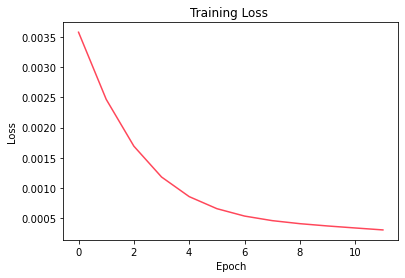

In [49]:
loss,feature_layer, rec_X = train()
 
print(loss)
plot_loss_with_acc(loss, [])

In [51]:
feature_np=feature_layer.detach().numpy()

kmeans = KMeans(n_clusters=60,init='k-means++').fit(feature_np)
print('purity : ',purity_score(labelList,kmeans.labels_ ))
print('ARI : ',adjusted_rand_score(labelList,kmeans.labels_))
print('NMI : ',normalized_mutual_info_score(labelList,kmeans.labels_ ))
print('homogeneity : ',homogeneity_score(labelList,kmeans.labels_))
print('completeness : ',completeness_score(labelList,kmeans.labels_ ))

purity :  0.6811118518898405
ARI :  0.10433882982535207
NMI :  0.4210480744798187
homogeneity :  0.5708911683564131
completeness :  0.3335107539209662


 ## ignore similar contigs thrown by metabat2

In [53]:

kmeans = KMeans(n_clusters=35,init='k-means++').fit(feature_np[metebat2_idx])

print('purity : ',purity_score(labelList[metebat2_idx],kmeans.labels_ ))
print('ARI : ',adjusted_rand_score(labelList[metebat2_idx],kmeans.labels_))
print('NMI : ',normalized_mutual_info_score(labelList[metebat2_idx],kmeans.labels_ ))
print('homogeneity : ',homogeneity_score(labelList[metebat2_idx],kmeans.labels_))
print('completeness : ',completeness_score(labelList[metebat2_idx],kmeans.labels_ ))

purity :  0.7463939155520587
ARI :  0.2964126851135429
NMI :  0.6646774810034917
homogeneity :  0.7483655026914384
completeness :  0.5978241574901993
